[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IvanNece/Detection-of-Anomalies-with-Localization/blob/main/notebooks/06_evaluation_clean.ipynb)

# 06 - Evaluation Clean Domain

**Phase 5: Threshold Calibration & Evaluation - Clean Domain**

This notebook implements the complete evaluation pipeline:
1. Load trained models (PatchCore & PaDiM)
2. Calibrate thresholds on Val-clean (F1-optimal)
3. Evaluate on Test-clean (image-level & pixel-level metrics)
4. Generate visualizations (ROC, PR curves, confusion matrices)
5. Save all results

**Metrics computed:**
- Image-level: AUROC, AUPRC, F1, Accuracy, Precision, Recall
- Pixel-level: Pixel AUROC, PRO (Per-Region Overlap)

## 1. Setup & Configuration

In [1]:
# ============================================================
# SETUP - Mount Google Drive & Clone Repository
# ============================================================

from google.colab import drive
from pathlib import Path
import os
import sys

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Done!\n")

# Clone repository on main branch
print("Cloning repository (branch: main)...")
repo_dir = '/content/Detection-of-Anomalies-with-Localization'

# Remove if exists
if os.path.exists(repo_dir):
    print("Removing existing repository...")
    !rm -rf {repo_dir}

# Clone from main branch
!git clone https://github.com/IvanNece/Detection-of-Anomalies-with-Localization.git {repo_dir}
print("Done!\n")

# Setup paths
PROJECT_ROOT = Path(repo_dir)

# Dataset location (direct from Drive, no duplication)
DATASET_PATH = Path('/content/drive/MyDrive/mvtec_ad')

# Output directories on Drive (User specific structure)
DRIVE_ROOT = Path('/content/drive/MyDrive/anomaly_detection_project')
PATCHCORE_MODELS_DIR = DRIVE_ROOT / '04_patchcore_clean_outputs'
PADIM_MODELS_DIR = DRIVE_ROOT / '05_padim_clean_outputs'

RESULTS_DIR = PROJECT_ROOT / 'outputs' / 'results'
THRESHOLDS_DIR = PROJECT_ROOT / 'outputs' / 'thresholds'
VIZ_DIR = PROJECT_ROOT / 'outputs' / 'visualizations' / 'phase5_clean'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
THRESHOLDS_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Verify dataset exists
if not DATASET_PATH.exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATASET_PATH}\n"
        f"Please ensure mvtec_ad folder is in your Google Drive root."
    )

# Add project root to Python path
sys.path.insert(0, str(PROJECT_ROOT))

print("\n" + "="*70)
print("SETUP COMPLETE")
print("="*70)
print(f"Project:   {PROJECT_ROOT}")
print(f"Dataset:   {DATASET_PATH}")
print(f"PatchCore: {PATCHCORE_MODELS_DIR}")
print(f"PaDiM:     {PADIM_MODELS_DIR}")
print(f"Results:   {RESULTS_DIR}")
print(f"Viz:       {VIZ_DIR}")
print("="*70)

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Done!

Cloning repository (branch: main)...
Removing existing repository...
Cloning into '/content/Detection-of-Anomalies-with-Localization'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 596 (delta 44), reused 61 (delta 18), pack-reused 477 (from 1)
Receiving objects: 100% (596/596), 177.83 MiB | 20.36 MiB/s, done.
Resolving deltas: 100% (324/324), done.
Updating files: 100% (72/72), done.
Done!


SETUP COMPLETE
Project:   /content/Detection-of-Anomalies-with-Localization
Dataset:   /content/drive/MyDrive/mvtec_ad
PatchCore: /content/drive/MyDrive/anomaly_detection_project/04_patchcore_clean_outputs
PaDiM:     /content/drive/MyDrive/anomaly_detection_project/05_padim_clean_outputs
Results:   /content/Detection-of-Anomalies-wit

In [9]:
# ============================================================
# INSTALL FAISS - MUST BE DONE BEFORE IMPORTS!
# ============================================================
# FAISS speeds up coreset sampling by 10-100x

!pip install faiss-cpu --quiet

# Verify installation
try:
    import faiss
    print("✓ FAISS installed successfully!")
    print(f" FAISS version: {faiss.__version__}")
    print("\n  IMPORTANT: Now you can proceed with imports")
except ImportError:
    print(" FAISS installation failed, will use numpy fallback (VERY SLOW)")
    print("   Try running: !pip install faiss-cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.4 MB/s eta 0:00:00
✓ FAISS installed successfully!
 FAISS version: 1.13.1

  IMPORTANT: Now you can proceed with imports


In [10]:
# Standard imports
import json
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Project imports
from src.utils.reproducibility import set_seed
from src.utils.config import load_config
from src.utils.paths import ProjectPaths
from src.data.splitter import load_splits
from src.data.dataset import MVTecDataset
from src.data.transforms import get_clean_transforms
from src.models.patchcore import PatchCore
from src.models.padim_wrapper import PadimWrapper

# Metrics imports
from src.metrics import (
    calibrate_threshold,
    calibrate_threshold_with_curve,
    ThresholdCalibrator,
    compute_image_metrics,
    compute_pixel_metrics,
    compute_roc_curve,
    compute_pr_curve,
    compute_confusion_matrix,
    aggregate_metrics,
    aggregate_pixel_metrics
)

from src.evaluation import Evaluator, MultiClassEvaluator

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
set_seed(42)

# Load configuration
config = load_config(PROJECT_ROOT / 'configs' / 'experiment_config.yaml')
paths = ProjectPaths(PROJECT_ROOT)

# Classes to evaluate
CLASSES = config.dataset.classes  # ['hazelnut', 'carpet', 'zipper']

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("=" * 60)
print("Phase 5: Threshold Calibration & Evaluation - Clean Domain")
print("=" * 60)
print(f"Using device: {DEVICE}")
print(f"Classes: {CLASSES}")

Random seed set to 42 for reproducibility
Loaded configuration from /content/Detection-of-Anomalies-with-Localization/configs/experiment_config.yaml
Phase 5: Threshold Calibration & Evaluation - Clean Domain
Using device: cpu
Classes: ['hazelnut', 'carpet', 'zipper']


## 2. Load Splits and Training Metadata

In [11]:
# Load clean splits
SPLITS_PATH = paths.get_split_path('clean')
splits = load_splits(SPLITS_PATH)

# Print split statistics
print("\nSplit Statistics:")
print("-" * 50)
for class_name in CLASSES:
    train_n = len(splits[class_name]['train']['images'])
    val_n = len(splits[class_name]['val']['images'])
    test_n = len(splits[class_name]['test']['images'])

    val_normal = sum(1 for l in splits[class_name]['val']['labels'] if l == 0)
    val_anom = sum(1 for l in splits[class_name]['val']['labels'] if l == 1)
    test_normal = sum(1 for l in splits[class_name]['test']['labels'] if l == 0)
    test_anom = sum(1 for l in splits[class_name]['test']['labels'] if l == 1)

    print(f"{class_name}:")
    print(f"  Train: {train_n} (all normal)")
    print(f"  Val: {val_n} ({val_normal} normal, {val_anom} anomalous)")
    print(f"  Test: {test_n} ({test_normal} normal, {test_anom} anomalous)")


Split Statistics:
--------------------------------------------------
hazelnut:
  Train: 312 (all normal)
  Val: 100 (79 normal, 21 anomalous)
  Test: 89 (40 normal, 49 anomalous)
carpet:
  Train: 224 (all normal)
  Val: 82 (56 normal, 26 anomalous)
  Test: 91 (28 normal, 63 anomalous)
zipper:
  Train: 192 (all normal)
  Val: 83 (48 normal, 35 anomalous)
  Test: 116 (32 normal, 84 anomalous)


In [12]:
# Load training metadata (contains validation predictions)
patchcore_metadata_path = RESULTS_DIR / 'patchcore_clean_metadata.json'
padim_metadata_path = RESULTS_DIR / 'padim_clean_metadata.json'

# Copy metadata from Drive if not present locally
if not patchcore_metadata_path.exists() and (PATCHCORE_MODELS_DIR / 'patchcore_clean_metadata.json').exists():
    import shutil
    shutil.copy(PATCHCORE_MODELS_DIR / 'patchcore_clean_metadata.json', patchcore_metadata_path)
    print("Copied patchcore metadata from Drive")

if not padim_metadata_path.exists() and (PADIM_MODELS_DIR / 'padim_clean_metadata.json').exists():
    import shutil
    shutil.copy(PADIM_MODELS_DIR / 'padim_clean_metadata.json', padim_metadata_path)
    print("Copied padim metadata from Drive")

with open(patchcore_metadata_path, 'r') as f:
    patchcore_metadata = json.load(f)

with open(padim_metadata_path, 'r') as f:
    padim_metadata = json.load(f)

print("Loaded training metadata for both methods.")
print(f"PatchCore trained on: {list(patchcore_metadata['training_statistics'].keys())}")
print(f"PaDiM trained on: {list(padim_metadata['training_statistics'].keys())}")

Loaded training metadata for both methods.
PatchCore trained on: ['hazelnut', 'carpet', 'zipper']
PaDiM trained on: ['hazelnut', 'carpet', 'zipper']


## 3. Threshold Calibration (Val-clean)

For each class and method, we find the F1-optimal threshold on the validation set.

In [13]:
# Initialize threshold calibrators
patchcore_calibrator = ThresholdCalibrator('patchcore')
padim_calibrator = ThresholdCalibrator('padim')

# Store calibration data for visualization
calibration_data = {
    'patchcore': {},
    'padim': {}
}

print("=" * 60)
print("THRESHOLD CALIBRATION (F1-Optimal on Val-clean)")
print("=" * 60)

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # PatchCore
    pc_val = patchcore_metadata['validation_predictions'][class_name]
    pc_scores = np.array(pc_val['scores'])
    pc_labels = np.array(pc_val['labels'])

    pc_threshold = patchcore_calibrator.calibrate(class_name, pc_scores, pc_labels)
    pc_thresh, pc_thresholds, pc_f1_scores = calibrate_threshold_with_curve(pc_scores, pc_labels)

    calibration_data['patchcore'][class_name] = {
        'scores': pc_scores,
        'labels': pc_labels,
        'threshold': pc_threshold,
        'threshold_curve': (pc_thresholds, pc_f1_scores)
    }

    # PaDiM
    pd_val = padim_metadata['validation_predictions'][class_name]
    pd_scores = np.array(pd_val['scores'])
    pd_labels = np.array(pd_val['labels'])

    pd_threshold = padim_calibrator.calibrate(class_name, pd_scores, pd_labels)
    pd_thresh, pd_thresholds, pd_f1_scores = calibrate_threshold_with_curve(pd_scores, pd_labels)

    calibration_data['padim'][class_name] = {
        'scores': pd_scores,
        'labels': pd_labels,
        'threshold': pd_threshold,
        'threshold_curve': (pd_thresholds, pd_f1_scores)
    }

# Save thresholds
patchcore_calibrator.save(THRESHOLDS_DIR / 'patchcore_clean_thresholds.json')
padim_calibrator.save(THRESHOLDS_DIR / 'padim_clean_thresholds.json')

print("\n" + "=" * 60)
print("Thresholds saved to outputs/thresholds/")
print("=" * 60)

THRESHOLD CALIBRATION (F1-Optimal on Val-clean)

--- HAZELNUT ---

--- CARPET ---

--- ZIPPER ---
[OK] Thresholds saved: patchcore_clean_thresholds.json
[OK] Thresholds saved: padim_clean_thresholds.json

Thresholds saved to outputs/thresholds/


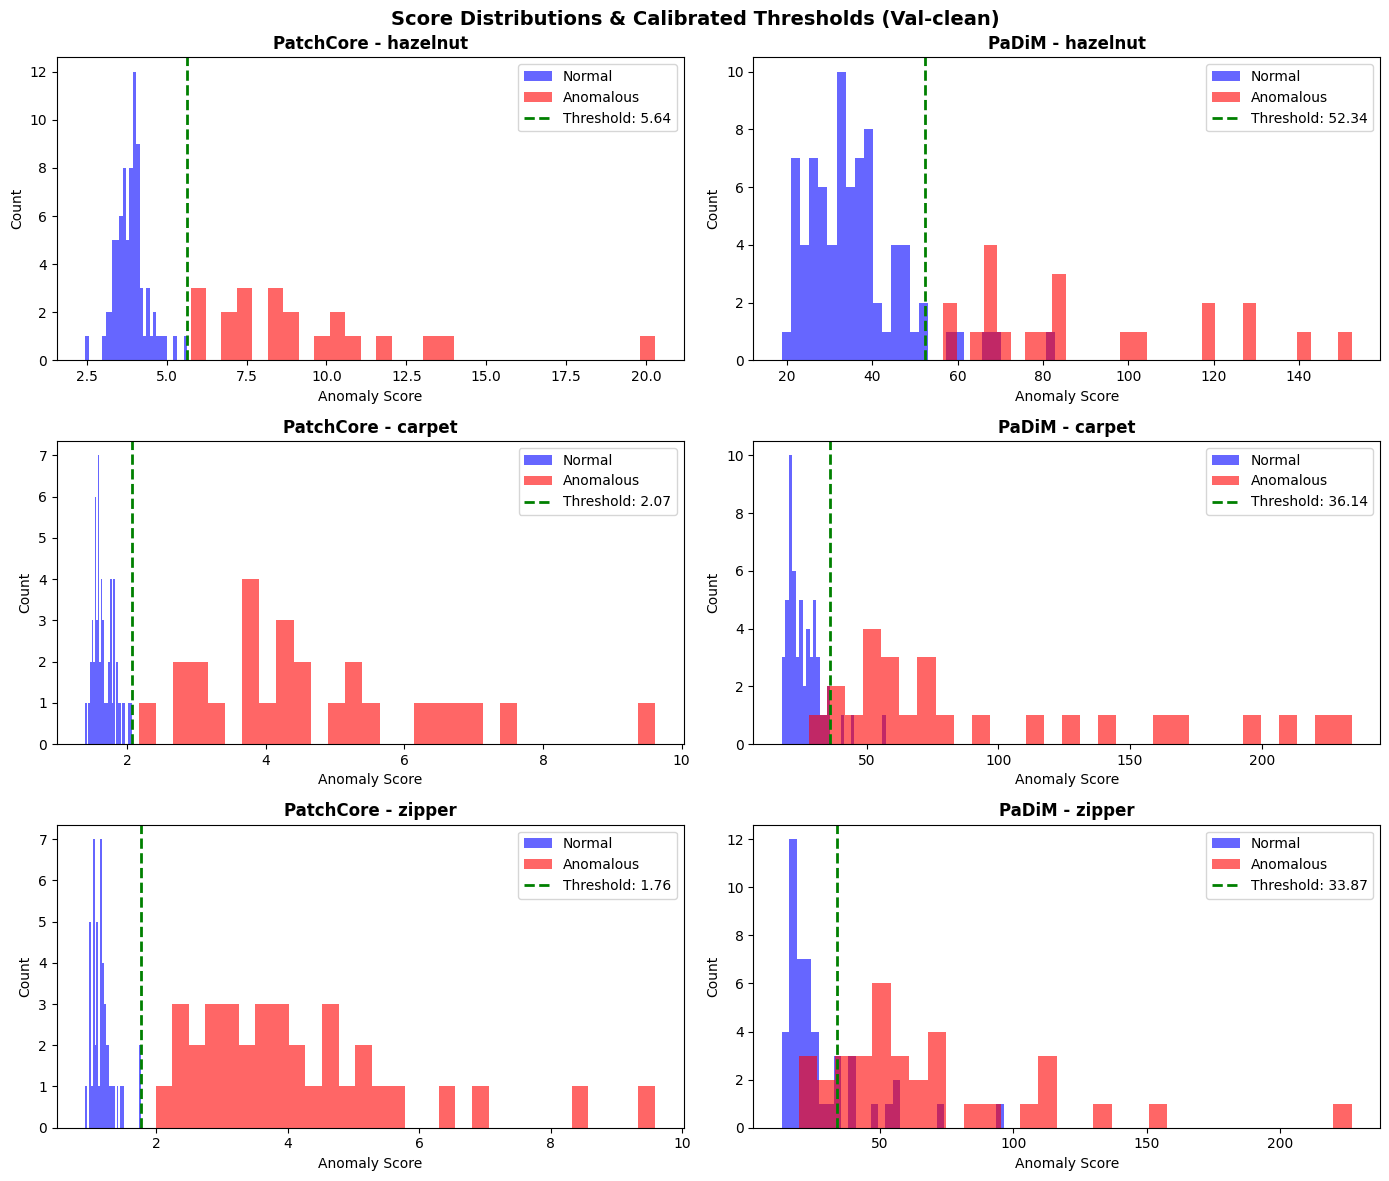

In [14]:
# Visualization: Score distributions and thresholds
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(14, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    # PatchCore
    ax1 = axes[i, 0]
    pc_data = calibration_data['patchcore'][class_name]
    normal_scores = pc_data['scores'][pc_data['labels'] == 0]
    anomalous_scores = pc_data['scores'][pc_data['labels'] == 1]

    ax1.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue')
    ax1.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red')
    ax1.axvline(pc_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pc_data["threshold"]:.2f}')
    ax1.set_title(f'PatchCore - {class_name}', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Anomaly Score')
    ax1.set_ylabel('Count')
    ax1.legend()

    # PaDiM
    ax2 = axes[i, 1]
    pd_data = calibration_data['padim'][class_name]
    normal_scores = pd_data['scores'][pd_data['labels'] == 0]
    anomalous_scores = pd_data['scores'][pd_data['labels'] == 1]

    ax2.hist(normal_scores, bins=30, alpha=0.6, label='Normal', color='blue')
    ax2.hist(anomalous_scores, bins=30, alpha=0.6, label='Anomalous', color='red')
    ax2.axvline(pd_data['threshold'], color='green', linestyle='--', linewidth=2,
                label=f'Threshold: {pd_data["threshold"]:.2f}')
    ax2.set_title(f'PaDiM - {class_name}', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Anomaly Score')
    ax2.set_ylabel('Count')
    ax2.legend()

plt.suptitle('Score Distributions & Calibrated Thresholds (Val-clean)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'score_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Image-Level Evaluation (Test-clean)

Now we evaluate on the test set using the calibrated thresholds.

In [15]:
# Get transforms
transform = get_clean_transforms(image_size=config.dataset.image_size)

# Load models and evaluate on test set
all_results = {
    'patchcore': {},
    'padim': {}
}

print("=" * 60)
print("IMAGE-LEVEL EVALUATION (Test-clean)")
print("=" * 60)

IMAGE-LEVEL EVALUATION (Test-clean)


In [16]:
# Evaluate PatchCore on each class
print("\n>>> PATCHCORE <<<")

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

    # Load model
    model = PatchCore(
        backbone_layers=config.patchcore.layers,
        patch_size=config.patchcore.patch_size,
        coreset_ratio=config.patchcore.coreset_sampling_ratio,
        n_neighbors=config.patchcore.n_neighbors,
        device=DEVICE
    )
    model.load(PATCHCORE_MODELS_DIR, class_name, domain='clean')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            all_scores.extend(scores.tolist())
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get threshold
    threshold = patchcore_calibrator.get_threshold(class_name)

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['patchcore'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold: {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")


>>> PATCHCORE <<<

--- HAZELNUT ---
✓ Using FAISS for fast k-NN search (memory bank: 12230 samples, 1536 dims)


Testing hazelnut:   0%|          | 0/12 [00:00<?, ?it/s]

TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [ ]:
# Evaluate PaDiM on each class
print("\n>>> PADIM <<<")

for class_name in CLASSES:
    print(f"\n--- {class_name.upper()} ---")

    # Create test dataset
    test_split = splits[class_name]['test']
    test_dataset = MVTecDataset.from_split(
        test_split,
        transform=transform,
        phase='test'
    )
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

    # Load model
    model = PadimWrapper(
        backbone=config.padim.backbone,
        layers=config.padim.layers,
        n_features=config.padim.n_features,
        image_size=config.dataset.image_size,
        device=DEVICE
    )
    model.load(PADIM_MODELS_DIR / f'padim_{class_name}_clean.pt')

    # Collect predictions
    all_scores = []
    all_labels = []
    all_heatmaps = []
    all_masks = []

    with torch.no_grad():
        for images, masks, labels, paths in tqdm(test_loader, desc=f'Testing {class_name}'):
            images = images.to(DEVICE)
            scores, heatmaps = model.predict(images, return_heatmaps=True)

            if isinstance(scores, np.ndarray):
                all_scores.extend(scores.flatten().tolist())
            else:
                all_scores.append(float(scores))
            all_labels.extend(labels.numpy().tolist())

            for mask in masks:
                if mask is not None:
                    all_masks.append(mask.numpy().squeeze())
                else:
                    all_masks.append(None)

            if heatmaps is not None:
                if heatmaps.ndim == 2:
                    all_heatmaps.append(heatmaps)
                else:
                    all_heatmaps.extend([h for h in heatmaps])

    # Convert to arrays
    test_scores = np.array(all_scores)
    test_labels = np.array(all_labels)

    # Get threshold
    threshold = padim_calibrator.get_threshold(class_name)

    # Compute image-level metrics
    image_metrics = compute_image_metrics(test_labels, test_scores, threshold=threshold)

    # Compute pixel-level metrics
    pixel_metrics = compute_pixel_metrics(all_masks, all_heatmaps, compute_pro_metric=True)

    # Store results
    all_results['padim'][class_name] = {
        'threshold': threshold,
        'image_level': image_metrics,
        'pixel_level': pixel_metrics,
        'test_scores': test_scores.tolist(),
        'test_labels': test_labels.tolist()
    }

    # Print results
    print(f"  Threshold: {threshold:.4f}")
    print(f"  AUROC: {image_metrics['auroc']:.4f}")
    print(f"  AUPRC: {image_metrics['auprc']:.4f}")
    print(f"  F1: {image_metrics['f1']:.4f}")
    print(f"  Pixel AUROC: {pixel_metrics.get('pixel_auroc', 'N/A')}")
    print(f"  PRO: {pixel_metrics.get('pro', 'N/A')}")

## 5. Macro-Average Results

In [ ]:
# Compute macro-averaged metrics
print("=" * 60)
print("MACRO-AVERAGE RESULTS")
print("=" * 60)

for method in ['patchcore', 'padim']:
    print(f"\n>>> {method.upper()} <<<")

    # Aggregate image-level
    image_metrics_per_class = {
        c: all_results[method][c]['image_level']
        for c in CLASSES
    }
    macro_image = aggregate_metrics(image_metrics_per_class)

    # Aggregate pixel-level
    pixel_metrics_per_class = {
        c: all_results[method][c]['pixel_level']
        for c in CLASSES
    }
    macro_pixel = aggregate_pixel_metrics(pixel_metrics_per_class)

    # Store
    all_results[method]['macro_average'] = {
        'image_level': macro_image,
        'pixel_level': macro_pixel
    }

    print(f"\nImage-Level (macro-avg):")
    print(f"  AUROC: {macro_image.get('auroc', 'N/A'):.4f}")
    print(f"  AUPRC: {macro_image.get('auprc', 'N/A'):.4f}")
    print(f"  F1: {macro_image.get('f1', 'N/A'):.4f}")
    print(f"  Accuracy: {macro_image.get('accuracy', 'N/A'):.4f}")

    print(f"\nPixel-Level (macro-avg):")
    print(f"  Pixel AUROC: {macro_pixel.get('pixel_auroc', 'N/A'):.4f}")
    print(f"  PRO: {macro_pixel.get('pro', 'N/A'):.4f}")

## 6. Visualizations

In [ ]:
# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['patchcore', 'padim']):
    ax = axes[idx]

    for class_name in CLASSES:
        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])

        fpr, tpr, _ = compute_roc_curve(labels, scores)
        auroc = all_results[method][class_name]['image_level']['auroc']

        ax.plot(fpr, tpr, label=f'{class_name} (AUROC={auroc:.3f})', linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title(f'{method.upper()} - ROC Curves', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Precision-Recall Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, method in enumerate(['patchcore', 'padim']):
    ax = axes[idx]

    for class_name in CLASSES:
        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])

        precision, recall, _ = compute_pr_curve(labels, scores)
        auprc = all_results[method][class_name]['image_level']['auprc']

        ax.plot(recall, precision, label=f'{class_name} (AUPRC={auprc:.3f})', linewidth=2)

    ax.set_xlabel('Recall', fontsize=12)
    ax.set_ylabel('Precision', fontsize=12)
    ax.set_title(f'{method.upper()} - Precision-Recall Curves', fontsize=14, fontweight='bold')
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / 'pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Confusion Matrices
fig, axes = plt.subplots(len(CLASSES), 2, figsize=(10, 4*len(CLASSES)))

for i, class_name in enumerate(CLASSES):
    for j, method in enumerate(['patchcore', 'padim']):
        ax = axes[i, j]

        scores = np.array(all_results[method][class_name]['test_scores'])
        labels = np.array(all_results[method][class_name]['test_labels'])
        threshold = all_results[method][class_name]['threshold']

        cm = compute_confusion_matrix(labels, scores, threshold)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Anomalous'],
                    yticklabels=['Normal', 'Anomalous'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'{method.upper()} - {class_name}', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrices (Test-clean)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Comparison Bar Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

metrics_to_plot = ['auroc', 'auprc', 'f1', 'accuracy']
x = np.arange(len(CLASSES))
width = 0.35

for idx, metric in enumerate(['auroc', 'f1']):
    ax = axes[idx]

    pc_values = [all_results['patchcore'][c]['image_level'][metric] for c in CLASSES]
    pd_values = [all_results['padim'][c]['image_level'][metric] for c in CLASSES]

    bars1 = ax.bar(x - width/2, pc_values, width, label='PatchCore', color='steelblue')
    bars2 = ax.bar(x + width/2, pd_values, width, label='PaDiM', color='darkorange')

    ax.set_xlabel('Class')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([c.capitalize() for c in CLASSES])
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=9)

plt.suptitle('PatchCore vs PaDiM - Clean Domain', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'method_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Save Results

In [ ]:
# Prepare final results
final_results = {
    'metadata': {
        'phase': 'Phase 5 - Evaluation Clean Domain',
        'timestamp': datetime.now().isoformat(),
        'seed': 42,
        'classes': CLASSES
    },
    'patchcore': {
        class_name: {
            'threshold': all_results['patchcore'][class_name]['threshold'],
            'image_level': all_results['patchcore'][class_name]['image_level'],
            'pixel_level': all_results['patchcore'][class_name]['pixel_level']
        }
        for class_name in CLASSES
    },
    'padim': {
        class_name: {
            'threshold': all_results['padim'][class_name]['threshold'],
            'image_level': all_results['padim'][class_name]['image_level'],
            'pixel_level': all_results['padim'][class_name]['pixel_level']
        }
        for class_name in CLASSES
    }
}

# Add macro-averages
final_results['patchcore']['macro_average'] = all_results['patchcore']['macro_average']
final_results['padim']['macro_average'] = all_results['padim']['macro_average']

# Save
results_path = RESULTS_DIR / 'clean_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2, default=str)

print(f"\n[OK] Results saved to: {results_path}")
print(f"[OK] Visualizations saved to: {VIZ_DIR}")

## 8. Summary Table

In [ ]:
import pandas as pd

# Create summary dataframe
rows = []
for method in ['patchcore', 'padim']:
    for class_name in CLASSES + ['macro_average']:
        if class_name == 'macro_average':
            img = all_results[method]['macro_average']['image_level']
            pix = all_results[method]['macro_average']['pixel_level']
            threshold = '-'
        else:
            img = all_results[method][class_name]['image_level']
            pix = all_results[method][class_name]['pixel_level']
            threshold = all_results[method][class_name]['threshold']

        rows.append({
            'Method': method.upper(),
            'Class': class_name.capitalize(),
            'Threshold': threshold if isinstance(threshold, str) else f'{threshold:.2f}',
            'AUROC': f"{img.get('auroc', 0):.4f}",
            'AUPRC': f"{img.get('auprc', 0):.4f}",
            'F1': f"{img.get('f1', 0):.4f}",
            'Accuracy': f"{img.get('accuracy', 0):.4f}",
            'Pixel AUROC': f"{pix.get('pixel_auroc', 0):.4f}" if pix.get('pixel_auroc') else '-',
            'PRO': f"{pix.get('pro', 0):.4f}" if pix.get('pro') else '-'
        })

df = pd.DataFrame(rows)
print("\n" + "=" * 100)
print("FINAL RESULTS SUMMARY - CLEAN DOMAIN")
print("=" * 100)
print(df.to_string(index=False))

# Save as CSV
df.to_csv(RESULTS_DIR / 'clean_results_summary.csv', index=False)
print(f"\n[OK] Summary saved to: {RESULTS_DIR / 'clean_results_summary.csv'}")

In [ ]:
print("\n" + "=" * 60)
print("PHASE 5 COMPLETED SUCCESSFULLY!")
print("=" * 60)
print(f"\nOutputs generated:")
print(f"  - {RESULTS_DIR / 'clean_results.json'}")
print(f"  - {RESULTS_DIR / 'clean_results_summary.csv'}")
print(f"  - {THRESHOLDS_DIR / 'patchcore_clean_thresholds.json'}")
print(f"  - {THRESHOLDS_DIR / 'padim_clean_thresholds.json'}")
print(f"  - Visualizations in {VIZ_DIR}")